# SageMaker Search

- THis is my own code running and learning about the code
---

## Conf

In [18]:
# !pip install --upgrade sagemaker

In [19]:
import sagemaker
import datetime
import boto3
from sagemaker import get_execution_role

def current_time():
    ct = datetime.datetime.now()
    return str(ct.now()).replace(":", "-").replace(" ", "-")[:19]

sess = sagemaker.Session()
bucket = "test-sagemaker-examples-1357942113492"
prefix = "DEMO-Search2"

tagKey = "Project"
tagValue = "Project_Binary_Classifier"
endpointName = "linear-learner-" + current_time()

role = get_execution_role()
region = boto3.Session().region_name

print(role)
print(endpointName)

arn:aws:iam::790592228004:role/service-role/AmazonSageMaker-ExecutionRole-20230510T135961
linear-learner-2023-05-25-09-12-34


---

## Data Ingestion

In [20]:
downloaded_data_bucket = f"jumpstart-cache-prod-{region}"
downloaded_data_prefix = "training-datasets/sm_search"

def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission

if check_bucket_permission(downloaded_data_bucket):
     print(f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}")

Downloaded training data will be read from s3://jumpstart-cache-prod-eu-west-1/training-datasets/sm_search


In [21]:
s3 = boto3.client("s3")

filename = "mnist.pkl.gz"
s3.download_file(
    downloaded_data_bucket,
    f'{downloaded_data_prefix}/{filename}',
    filename
)

In [22]:
%%time

import pickle, gzip, urllib.request, json
import numpy as np

with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 731 ms, sys: 261 ms, total: 992 ms
Wall time: 1.01 s


---

## Data Inspect

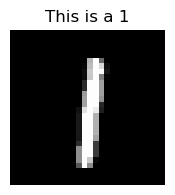

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption="", subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)
    
show_digit(train_set[0][40], "This is a {}".format(train_set[1][40]))

---

## Data Conversion

- Converting from numpy array to recordIO-wrapped protobuf

In [24]:
import io
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

with open('recordio-pb-data', 'wb') as f:
    f.write(buf.read())

In [25]:
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(
    prefix, 
    "train", 
    key)).upload_file("recordio-pb-data")

s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"Uploaded training data to: {s3_train_data}")

Uploaded training data to: s3://test-sagemaker-examples-1357942113492/DEMO-Search2/train/recordio-pb-data


In [26]:
!aws s3 ls s3://{bucket}/{prefix}/train/recordio-pb-data

2023-05-25 09:12:58  159200000 recordio-pb-data


In [27]:
output_location_1 = "s3://{}/{}/output-1".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location_1))

training artifacts will be uploaded to: s3://test-sagemaker-examples-1357942113492/DEMO-Search2/output-1


In [28]:
from sagemaker.image_uris import retrieve
container = retrieve("linear-learner", region)
print("Model container: ", container)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Model container:  438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:1


In [29]:
import time
job_name = "train-search-example-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Job name: ", job_name)

train_use_spot = True
train_max_run = 1800
train_max_wait = 3600 if train_use_spot else None
checkpoint_s3_uri = (f's3://{bucket}/{prefix}/checkpoints/{job_name}' if train_use_spot else none)

instance_type = "ml.c4.xlarge"

Job name:  train-search-example-2023-05-25-09-13-01


In [30]:
smclient = boto3.client(service_name="sagemaker")
session = sagemaker.session.Session(sagemaker_client=smclient)

linear_1 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location_1,
    tags=[{"Key": tagKey, "Value": tagValue}],
    sagemaker_session=session,
    use_spot_instances=train_use_spot,
    max_run=train_max_run,
    max_wait=train_max_wait,
    checkpoint_s3_uri=checkpoint_s3_uri
)

linear_1.set_hyperparameters(
    feature_dim=784,
    predictor_type="binary_classifier",
    mini_batch_size=200
)

linear_1.fit({"train": s3_train_data}, job_name=job_name, logs="Training")

INFO:sagemaker:Creating training-job with name: train-search-example-2023-05-25-09-13-01


2023-05-25 09:13:07 Starting - Starting the training job...
2023-05-25 09:13:31 Starting - Preparing the instances for training......
2023-05-25 09:14:22 Downloading - Downloading input data.........
2023-05-25 09:16:03 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/25/2023 09:16:15 INFO 140454544996160] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_delta':

In [34]:
output_loc_2 = f"s3://{bucket}/{prefix}/output-2"

job_name_2 = "jumpstart-example-train-sm-search-2-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("job name=", job_name_2)
checkpoint_s3_uri = (f's3://{bucket}/{prefix}/checkpoints/{job_name_2}' if train_use_spot else none)

linear_2 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_loc_2,
    tags=[{"Key": tagKey, "Value": tagValue}],
    sagemaker_session=session,
    use_spot_instances=train_use_spot,
    max_run=train_max_run,
    max_wait=train_max_wait,
    checkpoint_s3_uri=checkpoint_s3_uri
)

linear_2.set_hyperparameters(
    feature_dim=784,
    predictor_type="binary_classifier",
    mini_batch_size=100
)

linear_2.fit({"train": s3_train_data}, job_name_2, logs="Rules")

INFO:sagemaker:Creating training-job with name: linear-learner-2023-05-25-09-20-51-722


job name= jumpstart-example-train-sm-search-2-2023-05-25-09-20-51
2023-05-25 09:20:51 Starting - Starting the training job...
2023-05-25 09:21:15 Starting - Preparing the instances for training......
2023-05-25 09:22:16 Downloading - Downloading input data......
2023-05-25 09:23:22 Training - Downloading the training image......
2023-05-25 09:24:03 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/25/2023 09:24:10 INFO 140152799332160] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'ini

In [ ]:
# S3 location for third model version
output_location_3 = "s3://{}/{}/output-3".format(bucket, prefix)

job_name_3 = "jumpstart-example-train-sm-search-3-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("job name=", job_name_3)
checkpoint_s3_uri = (f's3://{bucket}/{prefix}/checkpoints/{job_name_3}' if train_use_spot else none)

linear_3 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location_3,
    tags=[{"Key": tagKey, "Value": tagValue}],
    sagemaker_session=session,
    use_spot_instances=train_use_spot,
    max_run=train_max_run,
    max_wait=train_max_wait,
    checkpoint_s3_uri=checkpoint_s3_uri
)

linear_3.set_hyperparameters(
    feature_dim=784, 
    predictor_type="binary_classifier", 
    mini_batch_size=300
)

linear_3.fit({"train": s3_train_data}, wait=False, job_name = job_name_3, logs="None")

INFO:sagemaker:Creating training-job with name: jumpstart-example-train-sm-search-3-2023-05-25-09-34-18


job name= jumpstart-example-train-sm-search-3-2023-05-25-09-34-18


In [38]:
import pandas as pd

search_params = {
    "MaxResults": 10,
    "Resource": "TrainingJob",
    "SearchExpression": {
        "Filters": [
            {"Name": "Tags." + str(tagKey), "Operator": "Equals", "Value": tagValue},
            {"Name": "TrainingJobStatus", "Operator": "Equals", "Value": "Completed"},
        ]
    },
    "SortBy": "Metrics.train:objective_loss:final",
    "SortOrder": "Ascending",
}
results = smclient.search(**search_params)
print("Search Query returned", str(len(results["Results"])), "training jobs. \n")

Search Query returned 7 training jobs. 



---

## Visualize the leaderboard

,Training Job Name,Training Job Status,Mini Batch Size,Objective Loss
0,linear-learner-2023-05-25-07-16-36-527,Completed,100,0.022989
1,linear-learner-2023-05-25-09-20-51-722,Completed,100,0.022989
2,train-search-example-2023-05-25-07-10-21,Completed,200,0.022991
3,train-search-example-2023-05-25-09-13-01,Completed,200,0.022991
4,jumpstart-example-train-sm-search-3-2023-05-25-07-25-06,Completed,300,0.023285
5,jumpstart-example-train-sm-search-3-2023-05-25-09-29-15,Completed,300,0.023285
6,jumpstart-example-train-sm-search-3-2023-05-25-09-34-18,Completed,300,0.023285


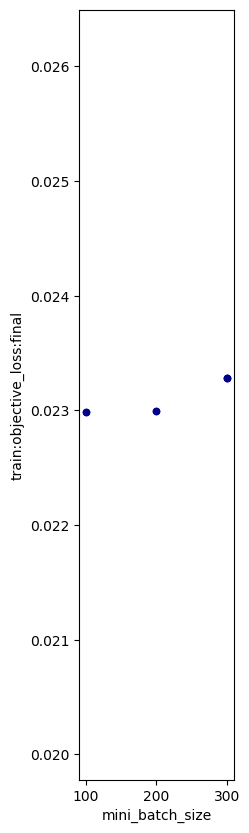

In [39]:
rows = []
coord = []

for result in results["Results"]:
    training_job = result["TrainingJob"]
    metrics = training_job["FinalMetricDataList"]
    accuracy = metrics[
        [x["MetricName"] for x in metrics].index("train:objective_loss:final")]["Value"]
    rows.append([
        training_job["TrainingJobName"],
        training_job["TrainingJobStatus"],
        training_job["HyperParameters"]["mini_batch_size"],
        accuracy,
    ])
    coord.append([float(training_job["HyperParameters"]["mini_batch_size"]),
                  accuracy])
headers = ["Training Job Name", "Training Job Status", "Mini Batch Size", "Objective Loss"]
df = pd.DataFrame(data=rows, columns=headers)
from IPython.display import HTML

display(HTML(df.to_html()))

axes = ["mini_batch_size", "train:objective_loss:final"]
df = pd.DataFrame(data=coord, columns=axes)
ax1 = df.plot.scatter(x="mini_batch_size", y="train:objective_loss:final", c="DarkBlue")
ax1

---

## Setup Hosting

In [30]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

endpoint_name = "jumpstart-example-infer-sm-search-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(endpoint_name)

linear_predictor = linear_1.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

result = linear_predictor.predict(train_set[0][30:31])
print(result)

INFO:sagemaker:Creating model with name: linear-learner-2023-05-25-07-43-45-703


jumpstart-example-infer-sm-search-2023-05-25-07-43-45


INFO:sagemaker:Creating endpoint-config with name jumpstart-example-infer-sm-search-2023-05-25-07-43-45
INFO:sagemaker:Creating endpoint with name jumpstart-example-infer-sm-search-2023-05-25-07-43-45


-------!{'predictions': [{'score': 3.780501245387313e-08, 'predicted_label': 0}]}


In [35]:
endpoint_config = smclient.describe_endpoint_config(EndpointConfigName=endpoint_name)

model_name = endpoint_config["ProductionVariants"][0]["ModelName"]

model = smclient.describe_model(ModelName=model_name)
modelURI = model["PrimaryContainer"]["ModelDataUrl"]
print(str(modelURI))

search_params_ = {
    "MaxResults": 1,
    "Resource": "TrainingJob",
    "SearchExpression": {
        "Filters": [
            {"Name": "ModelArtifacts.S3ModelArtifacts", "Operator": "Equals", "Value": modelURI}
        ]
    },
}

results = smclient.search(**search_params)
print("Search query returned", str(len(results["Results"])), "training jobs.")

s3://test-sagemaker-examples-1357942113492/DEMO-Search/output-1/train-search-example-2023-05-25-07-10-21/output/model.tar.gz
Search query returned 3 training jobs.


In [37]:
trainingJob = results["Results"][0]["TrainingJob"]
metrics = trainingJob["FinalMetricDataList"]
metricnames = [x["MetricName"] for x in metrics]
metricvalues = [x["Value"] for x in metrics]
hyperparams = trainingJob["HyperParameters"]

headers = (
    ["Training Job Name", "Training Datasource URI", "Training Algorithm"]
    + list(hyperparams.keys())
    + metricnames
)
rows = []
rows.append(
    [
        trainingJob["TrainingJobName"],
        trainingJob["InputDataConfig"][0]["DataSource"]["S3DataSource"]["S3Uri"],
        trainingJob["AlgorithmSpecification"]["TrainingImage"],
    ]
    + list(hyperparams.values())
    + metricvalues
)

df = pd.DataFrame(data=rows, columns=headers)

# Set CSS properties for th elements in dataframe
th_props = [
    ("font-size", "11px"),
    ("text-align", "center"),
    ("font-weight", "bold"),
    ("color", "#6d6d6d"),
    ("background-color", "#f7f7f9"),
]

# Set CSS properties for td elements in dataframe
td_props = [("font-size", "11px"), ("text-align", "center")]

# Set table styles
styles = [dict(selector="th", props=th_props), dict(selector="td", props=td_props)]
html = df.style.set_table_styles(styles)
from IPython.display import display, HTML

html

,Training Job Name,Training Datasource URI,Training Algorithm,feature_dim,mini_batch_size,predictor_type,train:binary_f_beta,train:progress,train:objective_loss,train:binary_classification_accuracy,train:recall,train:precision,train:objective_loss:final,train:throughput
0,linear-learner-2023-05-25-07-16-36-527,s3://test-sagemaker-examples-1357942113492/DEMO-Search/train/recordio-pb-data,438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:1,784,100,binary_classifier,0.964744,100.000000,0.023559,0.993080,0.959854,0.969685,0.022989,3092.116211


In [39]:
# sess.delete_endpoint(linear_predictor.endpoint_name)